# kerasを使って話者識別モデルを作ろう
データベース：  
科警研DB 話者99人  
発話内容 ATR音素バランス文A50文  
  
実験：  
フレームレベルの認識  
発話内容open  
 A01-A05の5文で学習，A06-A10の5文で検証，A11-A50の40文で評価  
特徴量  
 対数MFB40bin×7フレーム

## ライブラリなどの準備

In [1]:
#ライブラリ群
import argparse
import numpy as np
from numpy.random import *
from tqdm import tqdm_notebook as tqdm
import keras
from keras.models import Sequential
from keras.initializers import TruncatedNormal
from keras.layers import Activation, Dense, Dropout
from keras.utils import np_utils
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.use("Agg")

#プログラムの引数
# parser = argparse.ArgumentParser(description="Speaker Varification")

# parser.add_argument( '--gpu', '-g', default = "0", type = str,
#                     help = 'GPU ID')
# parser.add_argument( '--gpu_use', '-gu', default = 0.3, type = float,
#                     help = 'GPU use rate')
# parser.add_argument( '--list_directory', '-ld', default="/net/venus/research3/B4system2019/keras_zemi/kakeiken/list",
#                     help = 'list directory')
# parser.add_argument( '--learn_input', '-li', default="mfb40_learn.lst",
#                     help = 'learn set')
# parser.add_argument( '--valid_input', '-vi', default="mfb40_valid.lst",
#                     help = 'valid set')
# parser.add_argument( '--test_input', '-ti', default="mfb40_test.lst",
#                     help = 'test set')
# parser.add_argument( '--input_node', '-in', default=40, type=int,
#                     help = 'number of input node')
# parser.add_argument( '--num_frame', '-nf', default=1, type=int,
#                     help = number of input frame)
# parser.add_argument( '--output_node', '-on', default=99, type=int,
#                     help = 'number of output node')
# parser.add_argument( '--batch', '-b', default=1000, type=int,
#                     help = 'learning minibatch size')
# parser.add_argument( '--epoch', '-e', default=100, type=int,
#                     help = 'number of epochs to learn')
# parser.add_argument( '--savemodel', '-sm', default='none',
#                     help = 'model file')
# parser.add_argument( '--loadmodel', '-lm', default='none',
#                     help = 'model file')
# args = parser.parse_args()

#parserの代わり
class Argument:
  gpu = "0"
  gpu_use=0.3
  list_directory = "/net/venus/research3/B4system2019/keras_zemi/kakeiken/list"
  learn_input = "mfb40_learn.lst"
  valid_input = "mfb40_valid.lst"
  test_input = "mfb40_test.lst"
  input_node = 40
  num_frame = 7
  output_node = 99
  batch = 1000
  epoch = 100
  savemodel = 'none'
  loadmodel = 'none'

args = Argument

config = tf.ConfigProto(
  gpu_options = tf.GPUOptions(
    visible_device_list=args.gpu,
    per_process_gpu_memory_fraction=args.gpu_use
  )
)
sess = tf.Session(config=config)
K.set_session(sess)

batchsize = args.batch
n_input = args.input_node
n_frame = args.num_frame
n_output = args.output_node
n_epoch = args.epoch

Using TensorFlow backend.


## 関数の準備
### file_read:リストファイルを読み込んでラベルと特徴量を返す
labels:1フレームごとのone-hotラベル  
features:1フレームごとの特徴量  
### nomalization:正規化処理を行う
各次元で学習データの平均分散を計算し，それを用いて正規化(標準化)を行う．

In [2]:
def file_read(lstfile):
  features_lst=[]
  labels_lst=[]
    
  with open(lstfile) as fp:
    for data in tqdm(fp):
      tmp = np.load(data.rstrip())
      #前後無音が入っているのでその部分は除去
      x = tmp['feature'][10:-40]
      y = tmp['label'][10:-40]
      i = 0
        
      #n_frame結合し，リストに格納
      for i in range(len(x) - n_frame):
        x_ = x[i:i+n_frame].reshape(n_input*n_frame)
        features_lst.append(x_)
        labels_lst.append(y[0])

  labels = np.array(np_utils.to_categorical(labels_lst), dtype = np.int32)
  features = np.array(features_lst, dtype = np.float32)
  return labels, features

def nomalization(features, mean, std):
  features=(features-mean)/std
  return features


## データ読み込み

In [3]:
#学習データ
print("learn data loding")
lstfile = args.list_directory + "/" + args.learn_input
learn_labels, learn_features = file_read(lstfile)
mean = np.mean(learn_features,axis=0)
std = np.std(learn_features,axis=0)
learn_features = nomalization(learn_features, mean, std)

#検証データ
print("valid data loding")
lstfile = args.list_directory + "/" + args.valid_input
valid_labels, valid_features = file_read(lstfile)
valid_features = nomalization(valid_features, mean, std)

#評価データ
print("test data loding")
lstfile = args.list_directory + "/" + args.test_input
test_labels, test_features = file_read(lstfile)
test_features = nomalization(test_features, mean, std)

print(np.shape(learn_labels),np.shape(learn_features))

learn data loding


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


valid data loding


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


test data loding


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


(185657, 99) (185657, 280)


## モデルの構築

In [4]:
TN = TruncatedNormal(seed=0) #切断正規分布

#自分で作ってみよう(input_dim=n_input*n_frame)
if args.loadmodel != 'none':
  model = load_model(args.loadmodel)
else:
  model = Sequential([
    Dense(700, input_dim=n_input*n_frame, kernel_initializer=TN),
    Activation('relu'),
    Dropout(0.2),
    Dense(400, kernel_initializer=TN),
    Activation('relu'),
    Dropout(0.2),
    Dense(100, kernel_initializer=TN),
    Activation('relu'),
    Dropout(0.2),
    Dense(n_output, activation='softmax')
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 700)               196700    
_________________________________________________________________
activation_1 (Activation)    (None, 700)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               280400    
_________________________________________________________________
activation_2 (Activation)    (None, 400)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               40100     
__________

## 学習

In [5]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
hist = model.fit(x=learn_features, y=learn_labels,
          batch_size=batchsize, epochs=n_epoch,
          validation_data=(valid_features,valid_labels))

Train on 185657 samples, validate on 224406 samples
Epoch 1/100
185657/185657 [==============================] - 2s 13us/step - loss: 3.4056 - acc: 0.1952 - val_loss: 2.3944 - val_acc: 0.4093
Epoch 2/100
185657/185657 [==============================] - 2s 11us/step - loss: 2.1613 - acc: 0.4375 - val_loss: 1.9029 - val_acc: 0.5133
Epoch 3/100
185657/185657 [==============================] - 2s 10us/step - loss: 1.7435 - acc: 0.5321 - val_loss: 1.6709 - val_acc: 0.5673
Epoch 4/100
185657/185657 [==============================] - 2s 10us/step - loss: 1.5089 - acc: 0.5889 - val_loss: 1.5292 - val_acc: 0.5993
Epoch 5/100
185657/185657 [==============================] - 2s 10us/step - loss: 1.3497 - acc: 0.6242 - val_loss: 1.4149 - val_acc: 0.6244
Epoch 6/100
185657/185657 [==============================] - 2s 10us/step - loss: 1.2377 - acc: 0.6537 - val_loss: 1.3429 - val_acc: 0.6398
Epoch 7/100
185657/185657 [==============================] - 2s 10us/step - loss: 1.1433 - acc: 0.6757 - val

Epoch 59/100
185657/185657 [==============================] - 2s 12us/step - loss: 0.4242 - acc: 0.8679 - val_loss: 1.0241 - val_acc: 0.7493
Epoch 60/100
185657/185657 [==============================] - 2s 12us/step - loss: 0.4191 - acc: 0.8696 - val_loss: 1.0078 - val_acc: 0.7522
Epoch 61/100
185657/185657 [==============================] - 2s 12us/step - loss: 0.4178 - acc: 0.8707 - val_loss: 1.0287 - val_acc: 0.7476
Epoch 62/100
185657/185657 [==============================] - 2s 12us/step - loss: 0.4126 - acc: 0.8713 - val_loss: 1.0544 - val_acc: 0.7432
Epoch 63/100
185657/185657 [==============================] - 2s 12us/step - loss: 0.4147 - acc: 0.8711 - val_loss: 1.0209 - val_acc: 0.7511
Epoch 64/100
185657/185657 [==============================] - 2s 12us/step - loss: 0.4080 - acc: 0.8737 - val_loss: 1.0198 - val_acc: 0.7505
Epoch 65/100
185657/185657 [==============================] - 2s 12us/step - loss: 0.4130 - acc: 0.8718 - val_loss: 1.0705 - val_acc: 0.7422
Epoch 66/100


## モデルの保存と学習曲線の表示

Text(0.5,1,'acc')

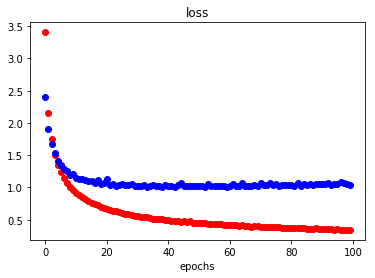

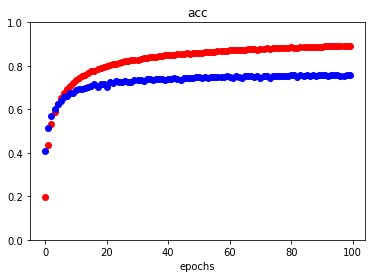

In [6]:
#モデルの保存
if args.savemodel != 'none':
  model.save(args.savemodel)

#loss
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]
fig = plt.figure()
plt.plot(range(len(loss)), loss, "bo", color="r", label="Training loss")
plt.plot(range(len(val_loss)), val_loss, "bo", color="b", label="validing loss")
plt.xlabel("epochs")
plt.title("loss")

#acc
acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
fig = plt.figure()
plt.ylim(0,1)
plt.plot(range(len(acc)), acc, "bo", color="r", label="Training acc")
plt.plot(range(len(val_acc)), val_acc, "bo", color="b", label="validing acc")
plt.xlabel("epochs")
plt.title("acc")

## フレームレベルの評価

In [7]:
#学習データ
predict = model.predict_classes(learn_features)
print("trainset error rate")
print(sum(predict != np.argmax(learn_labels, axis=1))/ len(learn_labels)*100)

predict = model.predict_classes(valid_features)
print("validset error rate")
print(sum(predict != np.argmax(valid_labels, axis=1))/ len(valid_labels)*100)

predict = model.predict_classes(test_features)
print("testset error rate")
print(sum(predict != np.argmax(test_labels, axis=1))/ len(test_labels)*100)

trainset error rate
3.5150842683012224
validset error rate
24.202561428838802
testset error rate
23.828872264855516
